# Import the libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold,KFold
import lightgbm as lgb

# Load the data

In [3]:
train = pd.read_csv('train.csv', parse_dates=['DateTime'], infer_datetime_format = True)
test = pd.read_csv('test.csv', parse_dates=['DateTime'], infer_datetime_format = True)
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
DateTime    11808 non-null datetime64[ns]
Junction    11808 non-null int64
ID          11808 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.9 KB


# Feature Engineering

## Distribution of my Target

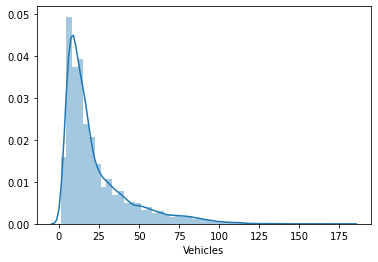

In [103]:
sns.distplot(train['Vehicles'])

## Add some columns extracted from DateTime column

In [6]:
for i in (train, test):
    i['Year'] = i.DateTime.dt.year
    i['Month'] = i.DateTime.dt.month
    i['Day'] = i.DateTime.dt.day
    i['Hour'] = i.DateTime.dt.hour
    i['Weekday'] = i.DateTime.dt.weekday_name

In [7]:
train = train.drop('DateTime', axis = 1)
test = test.drop('DateTime', axis = 1)

In [8]:
train.head()

,Junction,Vehicles,ID,Year,Month,Day,Hour,Weekday
0,1,15,20151101001,2015,11,1,0,Sunday
1,1,13,20151101011,2015,11,1,1,Sunday
2,1,10,20151101021,2015,11,1,2,Sunday
3,1,7,20151101031,2015,11,1,3,Sunday
4,1,9,20151101041,2015,11,1,4,Sunday


## BoxPlot of Hour vs Vehicles

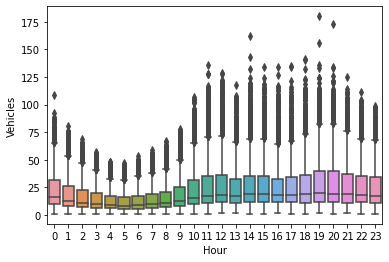

In [9]:
sns.boxplot(x = 'Hour', y = 'Vehicles', data = train)

**Findings**
- 4 am to 8 am the traffic is less because it's morning (sleeping time)

**To Do**
- Add a columns to check whether it's mornig or not.

In [10]:
Morning = []
for i in range(len(train)):
    if(train['Hour'][i]>3 and train['Hour'][i]<9):
        Morning.append('Yes')
    else:
        Morning.append('No')
        
train['Morning'] = Morning

Morning = []
for i in range(len(test)):
    if(train['Hour'][i]>3 and train['Hour'][i]<9):
        Morning.append('Yes')
    else:
        Morning.append('No')
        
test['Morning'] = Morning

**To Do**
- Add a column to check whether it's a weekday or not.

In [12]:
Weekday = []
for i in range(len(train)):
    if(train['Weekday'][i] == 'Sunday' or train['Weekday'][i] == 'Saturday'):
        Weekday.append('No')
    else:
        Weekday.append('Yes')
        
train['Weekday'] = Weekday

Weekday = []
for i in range(len(test)):
    if(train['Weekday'][i] == 'Sunday' or train['Weekday'][i] == 'Saturday'):
        Weekday.append('NO')
    else:
        Weekday.append('Yes')
        
test['Weekday'] = Weekday

## BoxPlot of day vs Vehicles

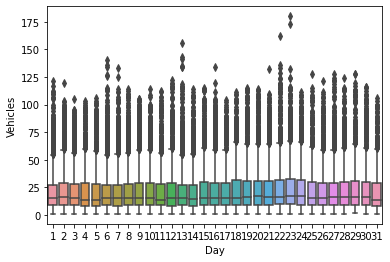

In [13]:
sns.boxplot(x = 'Day', y = 'Vehicles', data = train)

**No findings**

## BoxPlot of Junction vs Vehicles

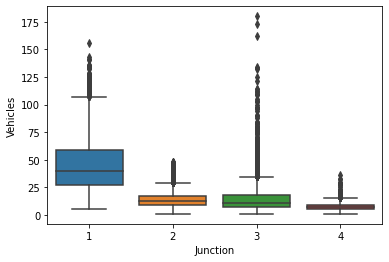

In [98]:
sns.boxplot(x = 'Junction', y = 'Vehicles', data = train)

**Findings**
- Junction 1 is the most crowded place.

**To Do**
- Add a column crowded to mark Junction 1 as a crowded place.

In [14]:
Crowded = []
for i in range(len(train)):
    if(train['Junction'][i]==1):
        Crowded.append('Yes')
    else:
        Crowded.append('No')
        
train['Crowded'] = Crowded

Crowded = []
for i in range(len(test)):
    if(test['Junction'][i]==1):
        Crowded.append('Yes')
    else:
        Crowded.append('No')
        
test['Crowded'] = Crowded

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 10 columns):
Junction    48120 non-null int64
Vehicles    48120 non-null int64
ID          48120 non-null int64
Year        48120 non-null int64
Month       48120 non-null int64
Day         48120 non-null int64
Hour        48120 non-null int64
Weekday     48120 non-null object
Morning     48120 non-null object
Crowded     48120 non-null object
dtypes: int64(7), object(3)
memory usage: 3.7+ MB


## BoxPlot of Year vs Vehicles

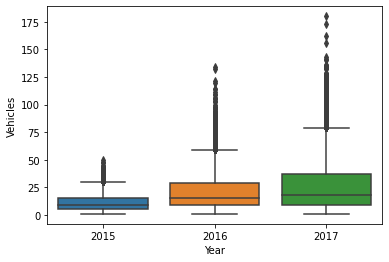

In [101]:
sns.boxplot(x = 'Year', y = 'Vehicles', data = train)

**Findings**
- Number of vehicles has increased by years.

In [102]:
train.head()

,Junction,Vehicles,ID,Year,Month,Day,Hour,Weekday,Morning,Crowded
0,1,15,20151101001,2015,11,1,0,No,No,Yes
1,1,13,20151101011,2015,11,1,1,No,No,Yes
2,1,10,20151101021,2015,11,1,2,No,No,Yes
3,1,7,20151101031,2015,11,1,3,No,No,Yes
4,1,9,20151101041,2015,11,1,4,No,Yes,Yes


# Model Building

## CatBoost

In [104]:
train.head()

,Junction,Vehicles,ID,Year,Month,Day,Hour,Weekday,Morning,Crowded
0,1,15,20151101001,2015,11,1,0,No,No,Yes
1,1,13,20151101011,2015,11,1,1,No,No,Yes
2,1,10,20151101021,2015,11,1,2,No,No,Yes
3,1,7,20151101031,2015,11,1,3,No,No,Yes
4,1,9,20151101041,2015,11,1,4,No,Yes,Yes


In [16]:

#from sklearn.metrics import accuracy_score


# Set up folds
K = 10
kf = KFold(n_splits = K, random_state = 7, shuffle = True)
#skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True)

OPTIMIZE_ROUNDS = False
MAX_ROUNDS = 2000

X = train.drop(columns=['ID', 'Vehicles'],axis=1)
y = train['Vehicles']
X_test = test.drop(columns=['ID'],axis=1)




#X_test = test.drop(columns=['Item_Identifier','Outlet_Identifier'], axis=1)
y_valid_pred = 0*y
y_test_pred = 0
rmse = 0
result={}
rmses = []
#specifying categorical variables indexes
cat_columns = ['Junction', 'Year', 'Month', 'Day', 'Hour', 'Crowded', 'Morning', 'Weekday']



#fitting catboost classifier model
j=1
model = CatBoostRegressor(n_estimators=MAX_ROUNDS,verbose=False, loss_function='RMSE', l2_leaf_reg = 20, depth = 2)

for i, (train_index, test_index) in enumerate(kf.split(X)):

#for train_index, test_index in skf.split(X, y):  
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", j)
    #print( "\nFold ", i)
    
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_valid, y_valid],cat_features=cat_columns,
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train, cat_features=cat_columns )
        
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(sqrt(mean_squared_error(y_valid,pred)))
    rmses.append(sqrt(mean_squared_error(y_valid,pred)))
    rmse+=sqrt(mean_squared_error(y_valid,pred))
    # Accumulate test set predictions
    y_test_pred += fit_model.predict(X_test)
    result[j]=np.abs(fit_model.predict(X_test))
    j+=1
results = y_test_pred / K  # Average test set predictions
print()
print('Mean RMSE: 'rmse/K)



Fold  1
7.346547427160647

Fold  2
7.035427693189906

Fold  3
7.099558369320403

Fold  4
7.01882495669459

Fold  5
6.955712942850781

Fold  6
7.004803151184154

Fold  7
6.885416376694797

Fold  8
7.165384010131351

Fold  9
7.6603901425409555

Fold  10
7.5599052332336685
7.173197030300126


# Submission

**Calculate mean of cross validations and submit**

In [17]:

d = pd.DataFrame()
for i in range(1, 11):
    d = pd.concat([d,pd.DataFrame(result[i])],axis=1)
d.columns=['1','2','3','4','5','6','7','8','9','10']

re = d.mean(axis=1)

In [18]:
sub.Vehicles = re
sub.to_csv('Submission_cb.csv',index = False)
